In [28]:
from google.colab import files

In [ ]:
# importer train_data.csv, test_data.csv, data.csv et dataset.csv
files.upload()

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df_train=pd.read_csv('train_data.csv')
df_test=pd.read_csv('test_data.csv')

# === Enrichissements externes ===

In [36]:
# @title [Audit anti-fuite] Vérifier que `data` ne contient pas d'infos de `test_data`
import pandas as pd
import numpy as np

# Chargement (adapte les chemins si besoin)
df_train = pd.read_csv("train_data.csv")
df_test  = pd.read_csv("test_data.csv")
df_data  = pd.read_csv("data.csv")

# Colonnes communes pour construire un fingerprint (catégorielles + continues arrondies)
common = list(set(df_train.columns) & set(df_test.columns) & set(df_data.columns))
cats   = [c for c in ["key","mode","explicit"] if c in common]
conts  = [c for c in ["tempo","duration_ms","danceability","energy","loudness"] if c in common]

def make_fingerprint(df, cats, conts):
    parts = []
    if cats:
        parts.append(df[cats].astype(str).agg("|".join, axis=1))
    for c in conts:
        x = pd.to_numeric(df[c], errors="coerce")
        if c == "duration_ms":
            parts.append((np.round(x/1000, 0)).astype("Int64").astype(str))   # secondes
        elif c == "tempo":
            parts.append((np.round(x/2, 0)*2).astype("Int64").astype(str))    # bpm pair le + proche
        elif c == "loudness":
            parts.append((np.round(x, 0)).astype("Int64").astype(str))        # dB arrondi à l'unité
        else:
            parts.append((np.round(x, 2)).astype(str))                        # 2 décimales
    if not parts:
        return pd.Series([""]*len(df))
    return pd.Series(["|".join(vals) for vals in zip(*parts)])

fp_test = make_fingerprint(df_test, cats, conts)
fp_data = make_fingerprint(df_data, cats, conts)
overlap = len(set(fp_test) & set(fp_data))

print("Colonnes utilisées pour le fingerprint:", cats + conts)
print("Taille test:", len(df_test), "| Taille data:", len(df_data))
print("⚠️ Overlap exact fingerprint(data ∩ test):", overlap)

if overlap == 0:
    print("✅ Aucun recouvrement détecté : `data` ne semble pas contenir de lignes de `test_data`.")
else:
    print("🚨 Attention : recouvrement non nul — revois les règles d’enrichissement.")

Colonnes utilisées pour le fingerprint: ['key', 'mode', 'explicit', 'tempo', 'duration_ms', 'danceability', 'energy', 'loudness']
Taille test: 28500 | Taille data: 170653
⚠️ Overlap exact fingerprint(data ∩ test): 0
✅ Aucun recouvrement détecté : `data` ne semble pas contenir de lignes de `test_data`.


In [37]:
# @title Enrichir df_train avec data.csv (anti-fuite, filtres de plausibilité, alignement colonnes)
import pandas as pd
import numpy as np
from typing import List

# === Chemins (adapte si besoin) ===
train_path = "train_data.csv"
test_path  = "test_data.csv"
data_path  = "data.csv"
out_path   = "train_augmented.csv"

# === 0) Chargement ===
df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)
df_data  = pd.read_csv(data_path)

# Suppression des colonnes 'index-like' si présentes
for col in ["Unnamed: 0", "index"]:
    if col in df_train.columns: df_train.drop(columns=col, inplace=True)
    if col in df_test.columns:  df_test.drop(columns=col, inplace=True)
    if col in df_data.columns:  df_data.drop(columns=col, inplace=True)

# === 1) Colonnes cibles de ta pipeline (on s'aligne automatiquement sur le train) ===
# On prend comme référence les colonnes du train pour l'ordre final
train_cols = list(df_train.columns)

# Quelques colonnes “candidates” utiles si présentes dans data
maybe_cat = ["track_genre", "time_signature", "explicit", "mode", "key"]
maybe_num = ["danceability","energy","loudness","speechiness","acousticness",
             "instrumentalness","liveness","valence","tempo","duration_ms","popularity"]

# === 2) Filtres de plausibilité sur data (conservateurs) ===
def plausible(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    # bornes type Spotify
    rng01 = ['danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence']
    for c in rng01:
        if c in d.columns:
            x = pd.to_numeric(d[c], errors='coerce')
            d = d[(x.isna()) | ((x >= 0) & (x <= 1))]
    if "tempo" in d.columns:
        x = pd.to_numeric(d["tempo"], errors='coerce')
        d = d[(x.isna()) | ((x > 0) & (x < 250))]
    if "duration_ms" in d.columns:
        x = pd.to_numeric(d["duration_ms"], errors='coerce')
        d = d[(x.isna()) | ((x > 5_000) & (x < 1.5e7))]  # 5s → ~4h
    if "loudness" in d.columns:
        x = pd.to_numeric(d["loudness"], errors='coerce')
        d = d[(x.isna()) | ((x >= -60) & (x <= 5))]
    return d

df_data_pl = plausible(df_data)

# === 3) Préparer des colonnes manquantes côté data (sans casser ton pipeline) ===
# a) Ajoute placeholders pour catégorielles manquantes
for c in maybe_cat:
    if (c not in df_data_pl.columns) and (c in train_cols):
        # placeholder “safe” : NaN sauf track_genre (‘unknown’ pour TE → moyenne globale)
        df_data_pl[c] = "unknown" if c == "track_genre" else np.nan

# b) Convertit numériques possibles
for c in maybe_num:
    if c in df_data_pl.columns:
        df_data_pl[c] = pd.to_numeric(df_data_pl[c], errors="coerce")

# c) Garde uniquement colonnes utiles (toutes celles présentes dans le train + target si dans data)
keep_cols = [c for c in train_cols if c in df_data_pl.columns]
missing_in_data = [c for c in train_cols if c not in df_data_pl.columns]

# Ajoute les colonnes du train manquantes côté data en NaN (pour pouvoir concaténer)
for c in missing_in_data:
    df_data_pl[c] = np.nan

# Réordonne comme le train
df_data_pl = df_data_pl[train_cols].copy()

# === 4) Fingerprint anti-duplication (éviter recouvrement avec train ET test) ===
# On fabrique une “empreinte” robuste à petites variations pour identifier des doublons probables
def make_fingerprint(df: pd.DataFrame) -> pd.Series:
    parts: List[pd.Series] = []

    # Catégories stables si existantes
    for c in ["key","mode","explicit"]:
        if c in df.columns:
            parts.append(df[c].astype(str))
    # Continues arrondies (stabilise la comparaison)
    def num_s(df, col, scale="raw"):
        x = pd.to_numeric(df[col], errors="coerce")
        if col == "duration_ms":
            return (x/1000).round().astype("Int64").astype(str)    # secondes
        if col == "tempo":
            return (np.round(x/2, 0)*2).astype("Int64").astype(str)# bpm pair
        if col == "loudness":
            return x.round().astype("Int64").astype(str)           # dB à l'unité
        return x.round(2).astype(str)                              # autres à 2 décimales

    for c in ["tempo","duration_ms","danceability","energy","loudness"]:
        if c in df.columns:
            parts.append(num_s(df, c))

    if not parts:
        return pd.Series([""]*len(df), index=df.index)

    return pd.Series(["|".join(vals) for vals in zip(*parts)], index=df.index)

fp_train = make_fingerprint(df_train)
fp_test  = make_fingerprint(df_test)
fp_data  = make_fingerprint(df_data_pl)

train_set = set(fp_train.dropna())
test_set  = set(fp_test.dropna())

mask_new = (~fp_data.isin(train_set)) & (~fp_data.isin(test_set))
df_new_rows = df_data_pl[mask_new].copy()

# === 5) Concaténer proprement & sauvegarder ===
df_train_aug = pd.concat([df_train, df_new_rows], ignore_index=True)

# Sauvegarde
df_train_aug.to_csv(out_path, index=False)

# Remplace df_train en mémoire (pour la suite du notebook)
df_train = df_train_aug

# === 6) Rapport succinct ===
print("✅ Enrichissement terminé (anti-fuite).")
print(f" - Lignes train AVANT : {len(fp_train):,}")
print(f" - Nouvelles lignes ajoutées depuis data : {len(df_new_rows):,}")
print(f" - Lignes train APRÈS : {len(df_train):,}")
print(f" - Fichier écrit : {out_path}")

✅ Enrichissement terminé (anti-fuite).
 - Lignes train AVANT : 85,500
 - Nouvelles lignes ajoutées depuis data : 170,510
 - Lignes train APRÈS : 256,010
 - Fichier écrit : train_augmented.csv


In [38]:
# @title [Enrichissement #2] Ajouter les lignes exploitables de dataset.csv (anti-fuite + alignement)
import pandas as pd
import numpy as np
from typing import List

# Hypothèses: df_train (déjà enrichi avec data.csv) et df_test sont en mémoire
# Fichiers:
ds_path = "dataset.csv"

# 0) Charger et nettoyer dataset
df_ds = pd.read_csv(ds_path)

# Drop colonnes index-like si présentes
for col in ["Unnamed: 0", "index"]:
    if col in df_ds.columns:
        df_ds.drop(columns=col, inplace=True)

# 1) Harmoniser les colonnes pour compatibilité concat
train_cols = list(df_train.columns)

# placeholders pour catégorielles utiles
for c in ["track_genre","time_signature","explicit","mode","key"]:
    if (c not in df_ds.columns) and (c in train_cols):
        df_ds[c] = "unknown" if c == "track_genre" else np.nan

# coercition numérique
for c in ["danceability","energy","loudness","speechiness","acousticness",
          "instrumentalness","liveness","valence","tempo","duration_ms","popularity"]:
    if c in df_ds.columns:
        df_ds[c] = pd.to_numeric(df_ds[c], errors="coerce")

# Filtres de plausibilité conservateurs
def plausible(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    rng01 = ['danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence']
    for c in rng01:
        if c in d.columns:
            x = pd.to_numeric(d[c], errors='coerce')
            d = d[(x.isna()) | ((x >= 0) & (x <= 1))]
    if "tempo" in d.columns:
        x = pd.to_numeric(d["tempo"], errors='coerce')
        d = d[(x.isna()) | ((x > 0) & (x < 250))]
    if "duration_ms" in d.columns:
        x = pd.to_numeric(d["duration_ms"], errors='coerce')
        d = d[(x.isna()) | ((x > 5_000) & (x < 1.5e7))]
    if "loudness" in d.columns:
        x = pd.to_numeric(d["loudness"], errors='coerce')
        d = d[(x.isna()) | ((x >= -60) & (x <= 5))]
    return d

df_ds = plausible(df_ds)

# 2) Fingerprint anti-duplication (éviter doublons avec train & test)
def make_fingerprint(df: pd.DataFrame) -> pd.Series:
    parts: List[pd.Series] = []
    for c in ["key","mode","explicit"]:
        if c in df.columns: parts.append(df[c].astype(str))
    def num_s(df, col):
        x = pd.to_numeric(df[col], errors="coerce")
        if col == "duration_ms": return (x/1000).round().astype("Int64").astype(str)
        if col == "tempo":       return (np.round(x/2,0)*2).astype("Int64").astype(str)
        if col == "loudness":    return x.round().astype("Int64").astype(str)
        return x.round(2).astype(str)
    for c in ["tempo","duration_ms","danceability","energy","loudness"]:
        if c in df.columns: parts.append(num_s(df, c))
    if not parts:
        return pd.Series([""]*len(df), index=df.index)
    return pd.Series(["|".join(vals) for vals in zip(*parts)], index=df.index)

fp_train = make_fingerprint(df_train)
fp_test  = make_fingerprint(df_test)
fp_ds    = make_fingerprint(df_ds)

mask_new = (~fp_ds.isin(set(fp_train.dropna()))) & (~fp_ds.isin(set(fp_test.dropna())))
df_ds_new = df_ds[mask_new].copy()

# 3) Aligner l'ordre des colonnes pour concat
missing_in_ds = [c for c in train_cols if c not in df_ds_new.columns]
for c in missing_in_ds:
    df_ds_new[c] = np.nan
df_ds_new = df_ds_new[train_cols].copy()

# 4) Concat → df_train enrichi (2ᵉ vague)
df_train = pd.concat([df_train, df_ds_new], ignore_index=True)

print("✅ Enrichissement #2 dataset.csv terminé.")
print(f" - Nouvelles lignes ajoutées depuis dataset.csv : {len(df_ds_new):,}")
print(f" - Nouvelles dimensions df_train : {df_train.shape}")

✅ Enrichissement #2 dataset.csv terminé.
 - Nouvelles lignes ajoutées depuis dataset.csv : 68,134
 - Nouvelles dimensions df_train : (324144, 17)


In [39]:
# @title [Features externes] Priors par ARTISTE / ALBUM / GENRE issus de dataset.csv (+ utilisables pour train & test)
import pandas as pd
import numpy as np

# Rechargement rapide de dataset pour calculer les priors (au cas où il n'est plus en mémoire)
df_ds = pd.read_csv("dataset.csv")
for col in ["Unnamed: 0","index"]:
    if col in df_ds.columns:
        df_ds.drop(columns=col, inplace=True)

# Cast numériques
for c in ["popularity","duration_ms","tempo","loudness"]:
    if c in df_ds.columns:
        df_ds[c] = pd.to_numeric(df_ds[c], errors="coerce")

GLOBAL_MEAN = float(pd.to_numeric(df_ds["popularity"], errors="coerce").mean())
def smooth_mean(cnt, mu, global_mu, m):
    return (cnt*mu + m*global_mu) / (cnt + m)

# 1) Priors par ARTISTE (si présent)
pri_artist = None
if "artists" in df_ds.columns:
    g = (df_ds
         .groupby("artists")["popularity"]
         .agg(['count','mean'])
         .rename(columns={'count':'cnt','mean':'mu'})
         .reset_index())
    g["ext_prior_artist_pop"] = smooth_mean(g["cnt"], g["mu"], GLOBAL_MEAN, m=200)
    g["artist_track_count"]   = g["cnt"]
    pri_artist = g[["artists","ext_prior_artist_pop","artist_track_count"]]

# 2) Priors par ALBUM (si présent)
pri_album = None
if "album_name" in df_ds.columns:
    g = (df_ds
         .groupby("album_name")["popularity"]
         .agg(['count','mean'])
         .rename(columns={'count':'cnt','mean':'mu'})
         .reset_index())
    g["ext_prior_album_pop"] = smooth_mean(g["cnt"], g["mu"], GLOBAL_MEAN, m=150)
    g["album_track_count"]   = g["cnt"]
    pri_album = g[["album_name","ext_prior_album_pop","album_track_count"]]

# 3) Prior par GENRE (utile pour anciennes lignes ne disposant pas d'artiste/album)
pri_genre = None
if "track_genre" in df_ds.columns:
    g = (df_ds
         .groupby("track_genre")["popularity"]
         .agg(['count','mean'])
         .rename(columns={'count':'cnt','mean':'mu'})
         .reset_index())
    g["ext_prior_genre_pop_ds"] = smooth_mean(g["cnt"], g["mu"], GLOBAL_MEAN, m=300)
    pri_genre = g[["track_genre","ext_prior_genre_pop_ds"]]

# 4) Merge de ces priors dans df_train et df_test (là où c'est possible)
def enrich_with_priors(df):
    out = df.copy()
    if (pri_artist is not None) and ("artists" in out.columns):
        out = out.merge(pri_artist, on="artists", how="left")
        # Indicateur simple: collaboration (plusieurs artistes)
        out["is_collab"] = out["artists"].astype(str).str.contains(r",|&|;| feat\. ", case=False, regex=True).astype(float)
    else:
        out["ext_prior_artist_pop"] = np.nan
        out["artist_track_count"]   = np.nan
        out["is_collab"]            = np.nan

    if (pri_album is not None) and ("album_name" in out.columns):
        out = out.merge(pri_album, on="album_name", how="left")
    else:
        out["ext_prior_album_pop"] = np.nan
        out["album_track_count"]   = np.nan

    if (pri_genre is not None) and ("track_genre" in out.columns):
        out = out.merge(pri_genre, on="track_genre", how="left")
    else:
        out["ext_prior_genre_pop_ds"] = np.nan

    # Colonne backoff générale (utilisable partout): artiste → album → genre → moyenne globale
    prior_cols = ["ext_prior_artist_pop","ext_prior_album_pop","ext_prior_genre_pop_ds"]
    out["ext_prior_pop_ds"] = np.nan
    for c in prior_cols:
        if c in out.columns:
            out["ext_prior_pop_ds"] = out["ext_prior_pop_ds"].fillna(out[c])
    out["ext_prior_pop_ds"] = out["ext_prior_pop_ds"].fillna(GLOBAL_MEAN)

    # Remplir les compteurs manquants par 0 (utile pour arbres)
    for c in ["artist_track_count","album_track_count"]:
        if c in out.columns:
            out[c] = out[c].fillna(0)

    return out

df_train = enrich_with_priors(df_train)
df_test  = enrich_with_priors(df_test)

print("✅ Priors externes ajoutés.")
cols_added = [c for c in ["ext_prior_artist_pop","artist_track_count","is_collab",
                          "ext_prior_album_pop","album_track_count",
                          "ext_prior_genre_pop_ds","ext_prior_pop_ds"] if c in df_train.columns]
print("Colonnes ajoutées:", cols_added)
print("df_train:", df_train.shape, " | df_test:", df_test.shape)

# >> A ce stade:
# - df_train contient nouvelles lignes (de dataset.csv) + priors (artiste/album/genre) + backoff 'ext_prior_pop_ds'
# - df_test contient priors genre (pour toutes lignes) et artiste/album si jamais ces colonnes existent après enrichissements précédents

✅ Priors externes ajoutés.
Colonnes ajoutées: ['ext_prior_artist_pop', 'artist_track_count', 'is_collab', 'ext_prior_album_pop', 'album_track_count', 'ext_prior_genre_pop_ds', 'ext_prior_pop_ds']
df_train: (324144, 24)  | df_test: (28500, 23)


# I - Corrélation des variables

## Analyse des données

In [ ]:
df_train.info()
df_test.info()

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [ ]:
var_continue=df_train.select_dtypes(include='float64').columns.tolist()+['duration_ms']
df_continue=df_train[var_continue]
df_continue.head()

,row_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,ext_prior_artist_pop,artist_track_count,is_collab,ext_prior_album_pop,album_track_count,ext_prior_genre_pop_ds,ext_prior_pop_ds,duration_ms
0,0.0,0.809,0.269,-17.422,0.1020,0.659,0.006490,0.1200,0.480,127.011,4.0,NaN,0.0,NaN,NaN,0.0,36.266585,36.266585,187159
1,1.0,0.724,0.280,-12.788,0.0303,0.755,0.000000,0.3260,0.527,106.966,4.0,NaN,0.0,NaN,NaN,0.0,40.349662,40.349662,145514
2,2.0,0.765,0.387,-6.799,0.1470,0.908,0.000000,0.1850,0.839,159.966,4.0,NaN,0.0,NaN,NaN,0.0,34.629662,34.629662,131226
3,3.0,0.598,0.447,-7.932,0.0404,0.224,0.000000,0.0704,0.365,123.855,4.0,NaN,0.0,NaN,NaN,0.0,39.318893,39.318893,194706
4,4.0,0.430,0.543,-6.296,0.0367,0.463,0.000523,0.0928,0.354,143.912,4.0,NaN,0.0,NaN,NaN,0.0,18.153508,18.153508,200461


In [ ]:
var_categorielle=['explicit','key','mode','time_signature','track_genre']
df_cat=df_train[var_categorielle]
df_cat.head()

,explicit,key,mode,time_signature,track_genre
0,1,0,1,4.0,swedish
1,0,9,1,4.0,acoustic
2,0,7,1,4.0,children
3,0,8,1,4.0,j-pop
4,0,8,1,4.0,jazz


## 1) Corrélations variable continue <-> variable continue

### Visualisation si les hypothèses sont vérifiées (linéarité, normalité, dispertion et outliers)

In [ ]:
# --- Cellule 1 : imports (Colab) ---
!pip -q install statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.api import qqplot
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.api import qqplot
from statsmodels.nonparametric.smoothers_lowess import lowess

def pearson_diagnostics_plots(df, x, y, sample=None):
    """
    Version compacte pour Colab :
    - Figures 2× plus petites (~6×7)
    - Police et légendes adaptées
    - Affichage fluide pour 4 graphiques côte à côte
    """
    d = df[[x, y]].dropna()
    if sample and len(d) > sample:
        d = d.sample(sample, random_state=42)

    X = d[[x]].values
    yv = d[y].values
    lr = LinearRegression().fit(X, yv)
    fitted = lr.predict(X)
    resid = yv - fitted
    resid_std = (resid - resid.mean()) / resid.std(ddof=1)

    # Figure plus petite (moitié de la taille précédente)
    fig, axes = plt.subplots(3, 2, figsize=(6.5, 7))
    axes = axes.ravel()

    title_style = dict(fontsize=9, weight='bold')
    label_style = dict(fontsize=8)

    # 1️⃣ Linéarité
    sns.scatterplot(x=d[x], y=d[y], ax=axes[0], s=10, alpha=0.6)
    xs = np.linspace(d[x].min(), d[x].max(), 200).reshape(-1, 1)
    axes[0].plot(xs, lr.predict(xs), color="red", linewidth=1.2, label="Régression linéaire")
    lo = lowess(yv, d[x].values, frac=0.3)
    axes[0].plot(lo[:, 0], lo[:, 1], color="orange", linestyle="--", linewidth=1.2, label="LOWESS")
    axes[0].set_title(f"1️⃣ Linéarité : {x} vs {y}", **title_style)
    axes[0].set_xlabel(x, **label_style)
    axes[0].set_ylabel(y, **label_style)
    axes[0].legend(fontsize=7)

    # 2️⃣ Homoscédasticité
    sns.scatterplot(x=fitted, y=resid, ax=axes[1], s=10, alpha=0.6)
    axes[1].axhline(0, color='red', linestyle='--', linewidth=0.8)
    axes[1].set_title(f"2️⃣ Résidus vs ajustés ({x}→{y})", **title_style)
    axes[1].set_xlabel(f"Ajustés {y}", **label_style)
    axes[1].set_ylabel("Résidus", **label_style)

    # 3️⃣ Normalité
    qqplot(resid, line="s", ax=axes[2])
    axes[2].set_title(f"3️⃣ QQ-plot résidus ({x}, {y})", **title_style)
    axes[2].set_xlabel("Quantiles théoriques", **label_style)
    axes[2].set_ylabel("Quantiles observés", **label_style)

    # 4️⃣ Scale–Location
    sns.scatterplot(x=fitted, y=np.abs(resid_std), ax=axes[3], s=10, alpha=0.6)
    axes[3].set_title(f"4️⃣ Variance constante : {x}→{y}", **title_style)
    axes[3].set_xlabel(f"Ajustés {y}", **label_style)
    axes[3].set_ylabel("|Résidus standardisés|", **label_style)

    # 5️⃣ Outliers sur X
    sns.boxplot(y=d[x], ax=axes[4], color="skyblue")
    axes[4].set_title(f"5️⃣ Outliers : {x}", **title_style)
    axes[4].set_ylabel(x, **label_style)

    # 6️⃣ Outliers sur Y
    sns.boxplot(y=d[y], ax=axes[5], color="lightgreen")
    axes[5].set_title(f"6️⃣ Outliers : {y}", **title_style)
    axes[5].set_ylabel(y, **label_style)

    plt.tight_layout(pad=1.2)
    plt.show()

In [ ]:
# Exemple d’usage :
for var_cont1 in var_continue:
  for var_cont2 in var_continue:
    if var_cont1 != var_cont2:
      pearson_diagnostics_plots(df_continue, x=var_cont1, y=var_cont2, sample=5000)

### Sélections des variables, couples de variables vérifiant les hypothèses

In [ ]:
# @title Linéarité
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

def couples_lineaires(df, min_r2=0.30, max_delta_quad=0.05, cols_num=None):
    if cols_num is None:
        cols_num = df.select_dtypes(include=np.number).columns.tolist()
    pairs = []
    for x, y in combinations(cols_num, 2):
        d = df[[x, y]].dropna()
        if len(d) < 10:
            continue
        X = d[[x]].values; yv = d[y].values
        # Linéaire
        lr = LinearRegression().fit(X, yv)
        r2_lin = r2_score(yv, lr.predict(X))
        # Quadratique (pour détecter une non-linéarité évidente)
        PF = PolynomialFeatures(degree=2, include_bias=False)
        Xq = PF.fit_transform(X)
        lrq = LinearRegression().fit(Xq, yv)
        r2_quad = r2_score(yv, lrq.predict(Xq))
        if (r2_lin >= min_r2) and ((r2_quad - r2_lin) < max_delta_quad):
            pairs.append((x, y))
    return pairs

# Exemple :
couples_lineaires(df_continue, min_r2=0.25, max_delta_quad=0.07)

[('row_id', 'artist_track_count'),
 ('row_id', 'album_track_count'),
 ('danceability', 'valence'),
 ('danceability', 'artist_track_count'),
 ('danceability', 'album_track_count'),
 ('energy', 'loudness'),
 ('energy', 'acousticness'),
 ('energy', 'artist_track_count'),
 ('energy', 'album_track_count'),
 ('loudness', 'acousticness'),
 ('loudness', 'artist_track_count'),
 ('loudness', 'album_track_count'),
 ('speechiness', 'artist_track_count'),
 ('speechiness', 'album_track_count'),
 ('acousticness', 'artist_track_count'),
 ('acousticness', 'album_track_count'),
 ('instrumentalness', 'artist_track_count'),
 ('instrumentalness', 'album_track_count'),
 ('liveness', 'artist_track_count'),
 ('liveness', 'album_track_count'),
 ('valence', 'artist_track_count'),
 ('valence', 'album_track_count'),
 ('tempo', 'artist_track_count'),
 ('tempo', 'album_track_count'),
 ('time_signature', 'artist_track_count'),
 ('time_signature', 'album_track_count'),
 ('artist_track_count', 'album_track_count'),
 (

In [ ]:
# @title Normalité
from scipy.stats import shapiro, normaltest

def couples_normaux(df, alpha=0.05, cols_num=None, max_shapiro_n=5000):
    if cols_num is None:
        cols_num = df.select_dtypes(include=np.number).columns.tolist()
    def p_normal(v):
        v = pd.Series(v).dropna().values
        if len(v) < 8:
            return 0.0
        if len(v) <= max_shapiro_n:
            return shapiro(v)[1]
        else:
            return normaltest(v)[1]
    pairs = []
    for x, y in combinations(cols_num, 2):
        px = p_normal(df[x]); py = p_normal(df[y])
        if (px > alpha) and (py > alpha):
            pairs.append((x, y))
    return pairs

# Exemple :
couples_normaux(df_continue, alpha=0.05)

[]

In [ ]:
# @title Dispertion (Homoscédasticité)
def couples_homoscedastiques(df, alpha=0.05, cols_num=None):
    if cols_num is None:
        cols_num = df.select_dtypes(include=np.number).columns.tolist()
    pairs = []
    for x, y in combinations(cols_num, 2):
        d = df[[x, y]].dropna()
        if len(d) < 10:
            continue
        X = sm.add_constant(d[[x]])
        model = sm.OLS(d[y], X).fit()
        # Breusch–Pagan
        bp_test = het_breuschpagan(model.resid, model.model.exog)
        pval = bp_test[3]  # p-value de la statistique F
        if pval > alpha:
            pairs.append((x, y))
    return pairs

# Exemple :
couples_homoscedastiques(df_continue, alpha=0.05)

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782

[('row_id', 'danceability'),
 ('row_id', 'energy'),
 ('row_id', 'loudness'),
 ('row_id', 'speechiness'),
 ('row_id', 'acousticness'),
 ('row_id', 'instrumentalness'),
 ('row_id', 'liveness'),
 ('row_id', 'valence'),
 ('row_id', 'tempo'),
 ('row_id', 'time_signature'),
 ('row_id', 'ext_prior_genre_pop_ds'),
 ('row_id', 'ext_prior_pop_ds'),
 ('row_id', 'duration_ms')]

In [ ]:
# @title Outliers
def couples_sans_outliers(df, max_frac_outliers=0.01, z_thresh=3.5, cols_num=None):
    if cols_num is None:
        cols_num = df.select_dtypes(include=np.number).columns.tolist()
    pairs = []
    for x, y in combinations(cols_num, 2):
        d = df[[x, y]].dropna()
        if len(d) < 10:
            continue
        zx = np.abs((d[x] - d[x].mean()) / d[x].std(ddof=1))
        zy = np.abs((d[y] - d[y].mean()) / d[y].std(ddof=1))
        frac = ((zx > z_thresh) | (zy > z_thresh)).mean()
        if frac <= max_frac_outliers:
            pairs.append((x, y))
    return pairs

# Exemple :
couples_sans_outliers(df_continue, max_frac_outliers=0.02, z_thresh=3.5)

[('row_id', 'danceability'),
 ('row_id', 'energy'),
 ('row_id', 'loudness'),
 ('row_id', 'speechiness'),
 ('row_id', 'acousticness'),
 ('row_id', 'instrumentalness'),
 ('row_id', 'valence'),
 ('row_id', 'tempo'),
 ('row_id', 'time_signature'),
 ('row_id', 'artist_track_count'),
 ('row_id', 'album_track_count'),
 ('row_id', 'ext_prior_genre_pop_ds'),
 ('row_id', 'ext_prior_pop_ds'),
 ('row_id', 'duration_ms'),
 ('danceability', 'energy'),
 ('danceability', 'loudness'),
 ('danceability', 'acousticness'),
 ('danceability', 'instrumentalness'),
 ('danceability', 'liveness'),
 ('danceability', 'valence'),
 ('danceability', 'tempo'),
 ('danceability', 'time_signature'),
 ('danceability', 'artist_track_count'),
 ('danceability', 'album_track_count'),
 ('danceability', 'ext_prior_genre_pop_ds'),
 ('danceability', 'ext_prior_pop_ds'),
 ('danceability', 'duration_ms'),
 ('energy', 'loudness'),
 ('energy', 'acousticness'),
 ('energy', 'instrumentalness'),
 ('energy', 'liveness'),
 ('energy', 'val

### Tests de Pearson et de Spearman

#### Pearson pour les couples avec une relation linéaire

In [ ]:
df_pearson1=df_continue[['acousticness','energy']]
df_pearson1.corr(method='pearson')

,acousticness,energy
acousticness,1.000000,-0.761365
energy,-0.761365,1.000000


In [ ]:
df_pearson2=df_continue[['acousticness','loudness']]
df_pearson2.corr(method='spearman')

,acousticness,loudness
acousticness,1.000000,-0.619099
loudness,-0.619099,1.000000


#### Spearman pour tout les couples

                          row_id  danceability    energy  loudness  \
row_id                  1.000000      0.000880 -0.000024  0.001233   
danceability            0.000880      1.000000  0.154050  0.195893   
energy                 -0.000024      0.154050  1.000000  0.808323   
loudness                0.001233      0.195893  0.808323  1.000000   
speechiness            -0.000386      0.200540  0.239811  0.142714   
acousticness           -0.001440     -0.162786 -0.764213 -0.619099   
instrumentalness       -0.001502     -0.219982 -0.150147 -0.326244   
liveness               -0.001728     -0.128593  0.119208  0.069721   
valence                 0.004789      0.490394  0.240035  0.190133   
tempo                  -0.005655     -0.011934  0.266621  0.219895   
time_signature         -0.002530      0.177741  0.159147  0.150281   
ext_prior_artist_pop         NaN           NaN       NaN       NaN   
artist_track_count           NaN           NaN       NaN       NaN   
is_collab           

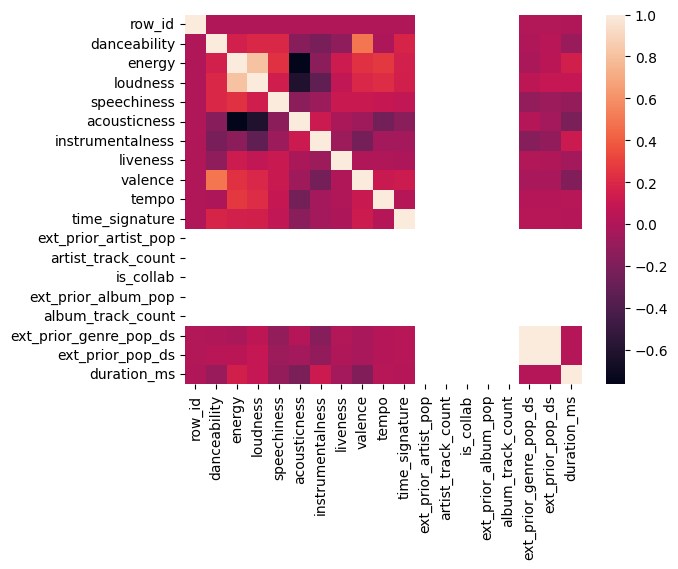

In [ ]:
corr_continue_spear=df_continue.corr(method='spearman')
print(corr_continue_spear)
sns.heatmap(corr_continue_spear)
plt.show()

## 2) Corrélations variable continue <-> variable catégorielle

### Test de normalité et de variances pour les distributions groupes par groupes pour chaque couple variable catégorielle <-> variable continue

In [ ]:
from scipy.stats import shapiro, levene

# Normalité (sur chaque groupe) si p<0.05 la distribution n'est probablement pas normale
for var_cont in var_continue:
  for var_cat in var_categorielle:
    for name, group in df_train.groupby(var_cat):
      stat, p = shapiro(group[f"{var_cont}"])
      # name correspond au nom du groupe par exemple dans track_genre -> acoustic
      print(f"{var_cont}-{var_cat}",f"group:{name}", "→ p =", round(p, 4))

row_id-explicit group:0 → p = nan
row_id-explicit group:1 → p = nan
row_id-key group:0 → p = nan
row_id-key group:1 → p = nan
row_id-key group:2 → p = nan
row_id-key group:3 → p = nan
row_id-key group:4 → p = nan
row_id-key group:5 → p = nan
row_id-key group:6 → p = nan
row_id-key group:7 → p = nan
row_id-key group:8 → p = nan
row_id-key group:9 → p = nan
row_id-key group:10 → p = nan
row_id-key group:11 → p = nan
row_id-mode group:0 → p = nan
row_id-mode group:1 → p = nan
row_id-time_signature group:0.0 → p = nan
row_id-time_signature group:1.0 → p = nan
row_id-time_signature group:3.0 → p = nan
row_id-time_signature group:4.0 → p = nan
row_id-time_signature group:5.0 → p = nan
row_id-track_genre group:acoustic → p = nan
row_id-track_genre group:afrobeat → p = nan
row_id-track_genre group:alt-rock → p = nan
row_id-track_genre group:alternative → p = nan
row_id-track_genre group:ambient → p = nan
row_id-track_genre group:anime → p = nan
row_id-track_genre group:black-metal → p = nan
ro

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27382.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy

danceability-explicit group:0 → p = 0.0
danceability-explicit group:1 → p = 0.0
danceability-key group:0 → p = 0.0
danceability-key group:1 → p = 0.0
danceability-key group:2 → p = 0.0
danceability-key group:3 → p = 0.0
danceability-key group:4 → p = 0.0
danceability-key group:5 → p = 0.0
danceability-key group:6 → p = 0.0
danceability-key group:7 → p = 0.0
danceability-key group:8 → p = 0.0
danceability-key group:9 → p = 0.0
danceability-key group:10 → p = 0.0
danceability-key group:11 → p = 0.0
danceability-mode group:0 → p = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 218335.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)


danceability-mode group:1 → p = 0.0
danceability-time_signature group:0.0 → p = 0.0
danceability-time_signature group:1.0 → p = 0.0
danceability-time_signature group:3.0 → p = 0.0
danceability-time_signature group:4.0 → p = 0.0
danceability-time_signature group:5.0 → p = 0.0
danceability-track_genre group:acoustic → p = 0.0
danceability-track_genre group:afrobeat → p = 0.0
danceability-track_genre group:alt-rock → p = 0.0
danceability-track_genre group:alternative → p = 0.0196
danceability-track_genre group:ambient → p = 0.0
danceability-track_genre group:anime → p = 0.0
danceability-track_genre group:black-metal → p = 0.0
danceability-track_genre group:bluegrass → p = 0.0001
danceability-track_genre group:blues → p = 0.0
danceability-track_genre group:brazil → p = 0.0
danceability-track_genre group:breakbeat → p = 0.0
danceability-track_genre group:british → p = 0.0
danceability-track_genre group:cantopop → p = 0.0
danceability-track_genre group:chicago-house → p = 0.0
danceability-tr

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scip

energy-key group:11 → p = 0.0
energy-mode group:0 → p = 0.0
energy-mode group:1 → p = 0.0
energy-time_signature group:0.0 → p = 0.0
energy-time_signature group:1.0 → p = 0.0
energy-time_signature group:3.0 → p = 0.0
energy-time_signature group:4.0 → p = 0.0
energy-time_signature group:5.0 → p = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105809.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 218335.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)


energy-track_genre group:acoustic → p = 0.0
energy-track_genre group:afrobeat → p = 0.0
energy-track_genre group:alt-rock → p = 0.0
energy-track_genre group:alternative → p = 0.0
energy-track_genre group:ambient → p = 0.0
energy-track_genre group:anime → p = 0.0
energy-track_genre group:black-metal → p = 0.0
energy-track_genre group:bluegrass → p = 0.0
energy-track_genre group:blues → p = 0.0
energy-track_genre group:brazil → p = 0.0
energy-track_genre group:breakbeat → p = 0.0
energy-track_genre group:british → p = 0.0
energy-track_genre group:cantopop → p = 0.0
energy-track_genre group:chicago-house → p = 0.0
energy-track_genre group:children → p = 0.0
energy-track_genre group:chill → p = 0.0
energy-track_genre group:classical → p = 0.0
energy-track_genre group:club → p = 0.0
energy-track_genre group:comedy → p = 0.0
energy-track_genre group:country → p = 0.0
energy-track_genre group:dance → p = 0.0
energy-track_genre group:dancehall → p = 0.0
energy-track_genre group:death-metal → p

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scip

loudness-key group:0 → p = 0.0
loudness-key group:1 → p = 0.0
loudness-key group:2 → p = 0.0
loudness-key group:3 → p = 0.0
loudness-key group:4 → p = 0.0
loudness-key group:5 → p = 0.0
loudness-key group:6 → p = 0.0
loudness-key group:7 → p = 0.0
loudness-key group:8 → p = 0.0
loudness-key group:9 → p = 0.0
loudness-key group:10 → p = 0.0
loudness-key group:11 → p = 0.0
loudness-mode group:0 → p = 0.0
loudness-mode group:1 → p = 0.0
loudness-time_signature group:0.0 → p = 0.0002
loudness-time_signature group:1.0 → p = 0.0
loudness-time_signature group:3.0 → p = 0.0
loudness-time_signature group:4.0 → p = 0.0
loudness-time_signature group:5.0 → p = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105809.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 218335.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)


loudness-track_genre group:acoustic → p = 0.0
loudness-track_genre group:afrobeat → p = 0.0
loudness-track_genre group:alt-rock → p = 0.0
loudness-track_genre group:alternative → p = 0.0
loudness-track_genre group:ambient → p = 0.0
loudness-track_genre group:anime → p = 0.0
loudness-track_genre group:black-metal → p = 0.0
loudness-track_genre group:bluegrass → p = 0.0
loudness-track_genre group:blues → p = 0.0
loudness-track_genre group:brazil → p = 0.0
loudness-track_genre group:breakbeat → p = 0.0
loudness-track_genre group:british → p = 0.0
loudness-track_genre group:cantopop → p = 0.0
loudness-track_genre group:chicago-house → p = 0.0
loudness-track_genre group:children → p = 0.0
loudness-track_genre group:chill → p = 0.0
loudness-track_genre group:classical → p = 0.0
loudness-track_genre group:club → p = 0.0
loudness-track_genre group:comedy → p = 0.0
loudness-track_genre group:country → p = 0.0
loudness-track_genre group:dance → p = 0.0
loudness-track_genre group:dancehall → p = 

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scip

speechiness-key group:0 → p = 0.0
speechiness-key group:1 → p = 0.0
speechiness-key group:2 → p = 0.0
speechiness-key group:3 → p = 0.0
speechiness-key group:4 → p = 0.0
speechiness-key group:5 → p = 0.0
speechiness-key group:6 → p = 0.0
speechiness-key group:7 → p = 0.0
speechiness-key group:8 → p = 0.0
speechiness-key group:9 → p = 0.0
speechiness-key group:10 → p = 0.0
speechiness-key group:11 → p = 0.0
speechiness-mode group:0 → p = 0.0
speechiness-mode group:1 → p = 0.0
speechiness-time_signature group:0.0 → p = 0.0
speechiness-time_signature group:1.0 → p = 0.0
speechiness-time_signature group:3.0 → p = 0.0
speechiness-time_signature group:4.0 → p = 0.0
speechiness-time_signature group:5.0 → p = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105809.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 218335.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)


speechiness-track_genre group:acoustic → p = 0.0
speechiness-track_genre group:afrobeat → p = 0.0
speechiness-track_genre group:alt-rock → p = 0.0
speechiness-track_genre group:alternative → p = 0.0
speechiness-track_genre group:ambient → p = 0.0
speechiness-track_genre group:anime → p = 0.0
speechiness-track_genre group:black-metal → p = 0.0
speechiness-track_genre group:bluegrass → p = 0.0
speechiness-track_genre group:blues → p = 0.0
speechiness-track_genre group:brazil → p = 0.0
speechiness-track_genre group:breakbeat → p = 0.0
speechiness-track_genre group:british → p = 0.0
speechiness-track_genre group:cantopop → p = 0.0
speechiness-track_genre group:chicago-house → p = 0.0
speechiness-track_genre group:children → p = 0.0
speechiness-track_genre group:chill → p = 0.0
speechiness-track_genre group:classical → p = 0.0
speechiness-track_genre group:club → p = 0.0
speechiness-track_genre group:comedy → p = 0.0
speechiness-track_genre group:country → p = 0.0
speechiness-track_genre gr

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scip

acousticness-key group:0 → p = 0.0
acousticness-key group:1 → p = 0.0
acousticness-key group:2 → p = 0.0
acousticness-key group:3 → p = 0.0
acousticness-key group:4 → p = 0.0
acousticness-key group:5 → p = 0.0
acousticness-key group:6 → p = 0.0
acousticness-key group:7 → p = 0.0
acousticness-key group:8 → p = 0.0
acousticness-key group:9 → p = 0.0
acousticness-key group:10 → p = 0.0
acousticness-key group:11 → p = 0.0
acousticness-mode group:0 → p = 0.0
acousticness-mode group:1 → p = 0.0
acousticness-time_signature group:0.0 → p = 0.0
acousticness-time_signature group:1.0 → p = 0.0
acousticness-time_signature group:3.0 → p = 0.0
acousticness-time_signature group:4.0 → p = 0.0
acousticness-time_signature group:5.0 → p = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105809.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 218335.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)


acousticness-track_genre group:acoustic → p = 0.0
acousticness-track_genre group:afrobeat → p = 0.0
acousticness-track_genre group:alt-rock → p = 0.0
acousticness-track_genre group:alternative → p = 0.0
acousticness-track_genre group:ambient → p = 0.0
acousticness-track_genre group:anime → p = 0.0
acousticness-track_genre group:black-metal → p = 0.0
acousticness-track_genre group:bluegrass → p = 0.0
acousticness-track_genre group:blues → p = 0.0
acousticness-track_genre group:brazil → p = 0.0
acousticness-track_genre group:breakbeat → p = 0.0
acousticness-track_genre group:british → p = 0.0
acousticness-track_genre group:cantopop → p = 0.0
acousticness-track_genre group:chicago-house → p = 0.0
acousticness-track_genre group:children → p = 0.0
acousticness-track_genre group:chill → p = 0.0
acousticness-track_genre group:classical → p = 0.0
acousticness-track_genre group:club → p = 0.0
acousticness-track_genre group:comedy → p = 0.0
acousticness-track_genre group:country → p = 0.0
acoust

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scip

instrumentalness-key group:0 → p = 0.0
instrumentalness-key group:1 → p = 0.0
instrumentalness-key group:2 → p = 0.0
instrumentalness-key group:3 → p = 0.0
instrumentalness-key group:4 → p = 0.0
instrumentalness-key group:5 → p = 0.0
instrumentalness-key group:6 → p = 0.0
instrumentalness-key group:7 → p = 0.0
instrumentalness-key group:8 → p = 0.0
instrumentalness-key group:9 → p = 0.0
instrumentalness-key group:10 → p = 0.0
instrumentalness-key group:11 → p = 0.0
instrumentalness-mode group:0 → p = 0.0
instrumentalness-mode group:1 → p = 0.0
instrumentalness-time_signature group:0.0 → p = 0.0
instrumentalness-time_signature group:1.0 → p = 0.0
instrumentalness-time_signature group:3.0 → p = 0.0
instrumentalness-time_signature group:4.0 → p = 0.0
instrumentalness-time_signature group:5.0 → p = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105809.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 218335.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)


instrumentalness-track_genre group:acoustic → p = 0.0
instrumentalness-track_genre group:afrobeat → p = 0.0
instrumentalness-track_genre group:alt-rock → p = 0.0
instrumentalness-track_genre group:alternative → p = 0.0
instrumentalness-track_genre group:ambient → p = 0.0
instrumentalness-track_genre group:anime → p = 0.0
instrumentalness-track_genre group:black-metal → p = 0.0
instrumentalness-track_genre group:bluegrass → p = 0.0
instrumentalness-track_genre group:blues → p = 0.0
instrumentalness-track_genre group:brazil → p = 0.0
instrumentalness-track_genre group:breakbeat → p = 0.0
instrumentalness-track_genre group:british → p = 0.0
instrumentalness-track_genre group:cantopop → p = 0.0
instrumentalness-track_genre group:chicago-house → p = 0.0
instrumentalness-track_genre group:children → p = 0.0
instrumentalness-track_genre group:chill → p = 0.0
instrumentalness-track_genre group:classical → p = 0.0
instrumentalness-track_genre group:club → p = 0.0
instrumentalness-track_genre gr

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scip

liveness-key group:0 → p = 0.0
liveness-key group:1 → p = 0.0
liveness-key group:2 → p = 0.0
liveness-key group:3 → p = 0.0
liveness-key group:4 → p = 0.0
liveness-key group:5 → p = 0.0
liveness-key group:6 → p = 0.0
liveness-key group:7 → p = 0.0
liveness-key group:8 → p = 0.0
liveness-key group:9 → p = 0.0
liveness-key group:10 → p = 0.0
liveness-key group:11 → p = 0.0
liveness-mode group:0 → p = 0.0
liveness-mode group:1 → p = 0.0
liveness-time_signature group:0.0 → p = 0.0
liveness-time_signature group:1.0 → p = 0.0
liveness-time_signature group:3.0 → p = 0.0
liveness-time_signature group:4.0 → p = 0.0
liveness-time_signature group:5.0 → p = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105809.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 218335.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)


liveness-track_genre group:acoustic → p = 0.0
liveness-track_genre group:afrobeat → p = 0.0
liveness-track_genre group:alt-rock → p = 0.0
liveness-track_genre group:alternative → p = 0.0
liveness-track_genre group:ambient → p = 0.0
liveness-track_genre group:anime → p = 0.0
liveness-track_genre group:black-metal → p = 0.0
liveness-track_genre group:bluegrass → p = 0.0
liveness-track_genre group:blues → p = 0.0
liveness-track_genre group:brazil → p = 0.0
liveness-track_genre group:breakbeat → p = 0.0
liveness-track_genre group:british → p = 0.0
liveness-track_genre group:cantopop → p = 0.0
liveness-track_genre group:chicago-house → p = 0.0
liveness-track_genre group:children → p = 0.0
liveness-track_genre group:chill → p = 0.0
liveness-track_genre group:classical → p = 0.0
liveness-track_genre group:club → p = 0.0
liveness-track_genre group:comedy → p = 0.0
liveness-track_genre group:country → p = 0.0
liveness-track_genre group:dance → p = 0.0
liveness-track_genre group:dancehall → p = 

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scip

valence-key group:0 → p = 0.0
valence-key group:1 → p = 0.0
valence-key group:2 → p = 0.0
valence-key group:3 → p = 0.0
valence-key group:4 → p = 0.0
valence-key group:5 → p = 0.0
valence-key group:6 → p = 0.0
valence-key group:7 → p = 0.0
valence-key group:8 → p = 0.0
valence-key group:9 → p = 0.0
valence-key group:10 → p = 0.0
valence-key group:11 → p = 0.0
valence-mode group:0 → p = 0.0
valence-mode group:1 → p = 0.0
valence-time_signature group:0.0 → p = 0.0
valence-time_signature group:1.0 → p = 0.0
valence-time_signature group:3.0 → p = 0.0
valence-time_signature group:4.0 → p = 0.0
valence-time_signature group:5.0 → p = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105809.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 218335.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)


valence-track_genre group:acoustic → p = 0.0
valence-track_genre group:afrobeat → p = 0.0
valence-track_genre group:alt-rock → p = 0.0
valence-track_genre group:alternative → p = 0.0
valence-track_genre group:ambient → p = 0.0
valence-track_genre group:anime → p = 0.0
valence-track_genre group:black-metal → p = 0.0
valence-track_genre group:bluegrass → p = 0.0
valence-track_genre group:blues → p = 0.0
valence-track_genre group:brazil → p = 0.0
valence-track_genre group:breakbeat → p = 0.0
valence-track_genre group:british → p = 0.0
valence-track_genre group:cantopop → p = 0.0
valence-track_genre group:chicago-house → p = 0.0
valence-track_genre group:children → p = 0.0
valence-track_genre group:chill → p = 0.0
valence-track_genre group:classical → p = 0.0
valence-track_genre group:club → p = 0.0
valence-track_genre group:comedy → p = 0.0
valence-track_genre group:country → p = 0.0
valence-track_genre group:dance → p = 0.0
valence-track_genre group:dancehall → p = 0.0
valence-track_genr

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scip

tempo-key group:0 → p = 0.0
tempo-key group:1 → p = 0.0
tempo-key group:2 → p = 0.0
tempo-key group:3 → p = 0.0
tempo-key group:4 → p = 0.0
tempo-key group:5 → p = 0.0
tempo-key group:6 → p = 0.0
tempo-key group:7 → p = 0.0
tempo-key group:8 → p = 0.0
tempo-key group:9 → p = 0.0
tempo-key group:10 → p = 0.0
tempo-key group:11 → p = 0.0
tempo-mode group:0 → p = 0.0
tempo-mode group:1 → p = 0.0
tempo-time_signature group:0.0 → p = 0.0
tempo-time_signature group:1.0 → p = 0.0
tempo-time_signature group:3.0 → p = 0.0
tempo-time_signature group:4.0 → p = 0.0
tempo-time_signature group:5.0 → p = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105809.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 218335.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)


tempo-track_genre group:acoustic → p = 0.0
tempo-track_genre group:afrobeat → p = 0.0
tempo-track_genre group:alt-rock → p = 0.0
tempo-track_genre group:alternative → p = 0.0
tempo-track_genre group:ambient → p = 0.0
tempo-track_genre group:anime → p = 0.0
tempo-track_genre group:black-metal → p = 0.0
tempo-track_genre group:bluegrass → p = 0.0
tempo-track_genre group:blues → p = 0.0
tempo-track_genre group:brazil → p = 0.0
tempo-track_genre group:breakbeat → p = 0.0
tempo-track_genre group:british → p = 0.0
tempo-track_genre group:cantopop → p = 0.0
tempo-track_genre group:chicago-house → p = 0.0
tempo-track_genre group:children → p = 0.0
tempo-track_genre group:chill → p = 0.0
tempo-track_genre group:classical → p = 0.0
tempo-track_genre group:club → p = 0.0
tempo-track_genre group:comedy → p = 0.0
tempo-track_genre group:country → p = 0.0
tempo-track_genre group:dance → p = 0.0
tempo-track_genre group:dancehall → p = 0.0
tempo-track_genre group:death-metal → p = 0.0
tempo-track_genr

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)


time_signature-key group:0 → p = nan
time_signature-key group:1 → p = nan
time_signature-key group:2 → p = nan
time_signature-key group:3 → p = nan
time_signature-key group:4 → p = nan
time_signature-key group:5 → p = nan
time_signature-key group:6 → p = nan
time_signature-key group:7 → p = nan
time_signature-key group:8 → p = nan
time_signature-key group:9 → p = nan
time_signature-key group:10 → p = nan
time_signature-key group:11 → p = nan
time_signature-mode group:0 → p = nan
time_signature-mode group:1 → p = nan
time_signature-time_signature group:0.0 → p = 1.0
time_signature-time_signature group:1.0 → p = 1.0
time_signature-time_signature group:3.0 → p = 1.0
time_signature-time_signature group:4.0 → p = 1.0
time_signature-time_signature group:5.0 → p = 1.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)


time_signature-track_genre group:acoustic → p = 0.0
time_signature-track_genre group:afrobeat → p = 0.0
time_signature-track_genre group:alt-rock → p = 0.0
time_signature-track_genre group:alternative → p = 0.0
time_signature-track_genre group:ambient → p = 0.0
time_signature-track_genre group:anime → p = 0.0
time_signature-track_genre group:black-metal → p = 0.0
time_signature-track_genre group:bluegrass → p = 0.0
time_signature-track_genre group:blues → p = 0.0
time_signature-track_genre group:brazil → p = 0.0
time_signature-track_genre group:breakbeat → p = 0.0
time_signature-track_genre group:british → p = 0.0
time_signature-track_genre group:cantopop → p = 0.0
time_signature-track_genre group:chicago-house → p = 0.0
time_signature-track_genre group:children → p = 0.0
time_signature-track_genre group:chill → p = 0.0
time_signature-track_genre group:classical → p = 0.0
time_signature-track_genre group:club → p = 0.0
time_signature-track_genre group:comedy → p = 0.0
time_signature-tr

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapi

artist_track_count-mode group:0 → p = 1.0
artist_track_count-mode group:1 → p = 1.0
artist_track_count-time_signature group:0.0 → p = 1.0
artist_track_count-time_signature group:1.0 → p = 1.0
artist_track_count-time_signature group:3.0 → p = 1.0
artist_track_count-time_signature group:4.0 → p = 1.0
artist_track_count-time_signature group:5.0 → p = 1.0
artist_track_count-track_genre group:acoustic → p = 1.0
artist_track_count-track_genre group:afrobeat → p = 1.0
artist_track_count-track_genre group:alt-rock → p = 1.0
artist_track_count-track_genre group:alternative → p = 1.0
artist_track_count-track_genre group:ambient → p = 1.0
artist_track_count-track_genre group:anime → p = 1.0
artist_track_count-track_genre group:black-metal → p = 1.0
artist_track_count-track_genre group:bluegrass → p = 1.0
artist_track_count-track_genre group:blues → p = 1.0
artist_track_count-track_genre group:brazil → p = 1.0
artist_track_count-track_genre group:breakbeat → p = 1.0
artist_track_count-track_genre 

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)


artist_track_count-track_genre group:electro → p = 1.0
artist_track_count-track_genre group:electronic → p = 1.0
artist_track_count-track_genre group:emo → p = 1.0
artist_track_count-track_genre group:folk → p = 1.0
artist_track_count-track_genre group:forro → p = 1.0
artist_track_count-track_genre group:french → p = 1.0
artist_track_count-track_genre group:funk → p = 1.0
artist_track_count-track_genre group:garage → p = 1.0
artist_track_count-track_genre group:german → p = 1.0
artist_track_count-track_genre group:gospel → p = 1.0
artist_track_count-track_genre group:goth → p = 1.0
artist_track_count-track_genre group:grindcore → p = 1.0
artist_track_count-track_genre group:groove → p = 1.0
artist_track_count-track_genre group:grunge → p = 1.0
artist_track_count-track_genre group:guitar → p = 1.0
artist_track_count-track_genre group:happy → p = 1.0
artist_track_count-track_genre group:hard-rock → p = 1.0
artist_track_count-track_genre group:hardcore → p = 1.0
artist_track_count-track_g

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapi

album_track_count-key group:0 → p = 1.0
album_track_count-key group:1 → p = 1.0
album_track_count-key group:2 → p = 1.0
album_track_count-key group:3 → p = 1.0
album_track_count-key group:4 → p = 1.0
album_track_count-key group:5 → p = 1.0
album_track_count-key group:6 → p = 1.0
album_track_count-key group:7 → p = 1.0
album_track_count-key group:8 → p = 1.0
album_track_count-key group:9 → p = 1.0
album_track_count-key group:10 → p = 1.0
album_track_count-key group:11 → p = 1.0
album_track_count-mode group:0 → p = 1.0
album_track_count-mode group:1 → p = 1.0
album_track_count-time_signature group:0.0 → p = 1.0
album_track_count-time_signature group:1.0 → p = 1.0
album_track_count-time_signature group:3.0 → p = 1.0
album_track_count-time_signature group:4.0 → p = 1.0
album_track_count-time_signature group:5.0 → p = 1.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


album_track_count-track_genre group:acoustic → p = 1.0
album_track_count-track_genre group:afrobeat → p = 1.0
album_track_count-track_genre group:alt-rock → p = 1.0
album_track_count-track_genre group:alternative → p = 1.0
album_track_count-track_genre group:ambient → p = 1.0
album_track_count-track_genre group:anime → p = 1.0
album_track_count-track_genre group:black-metal → p = 1.0
album_track_count-track_genre group:bluegrass → p = 1.0
album_track_count-track_genre group:blues → p = 1.0
album_track_count-track_genre group:brazil → p = 1.0
album_track_count-track_genre group:breakbeat → p = 1.0
album_track_count-track_genre group:british → p = 1.0
album_track_count-track_genre group:cantopop → p = 1.0
album_track_count-track_genre group:chicago-house → p = 1.0
album_track_count-track_genre group:children → p = 1.0
album_track_count-track_genre group:chill → p = 1.0
album_track_count-track_genre group:classical → p = 1.0
album_track_count-track_genre group:club → p = 1.0
album_track_c

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)


ext_prior_genre_pop_ds-key group:0 → p = nan
ext_prior_genre_pop_ds-key group:1 → p = nan
ext_prior_genre_pop_ds-key group:2 → p = nan
ext_prior_genre_pop_ds-key group:3 → p = nan
ext_prior_genre_pop_ds-key group:4 → p = nan
ext_prior_genre_pop_ds-key group:5 → p = nan
ext_prior_genre_pop_ds-key group:6 → p = nan
ext_prior_genre_pop_ds-key group:7 → p = nan
ext_prior_genre_pop_ds-key group:8 → p = nan
ext_prior_genre_pop_ds-key group:9 → p = nan
ext_prior_genre_pop_ds-key group:10 → p = nan
ext_prior_genre_pop_ds-key group:11 → p = nan
ext_prior_genre_pop_ds-mode group:0 → p = nan
ext_prior_genre_pop_ds-mode group:1 → p = nan
ext_prior_genre_pop_ds-time_signature group:0.0 → p = 0.0
ext_prior_genre_pop_ds-time_signature group:1.0 → p = 0.0
ext_prior_genre_pop_ds-time_signature group:3.0 → p = 0.0
ext_prior_genre_pop_ds-time_signature group:4.0 → p = 0.0
ext_prior_genre_pop_ds-time_signature group:5.0 → p = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


ext_prior_genre_pop_ds-track_genre group:acoustic → p = 1.0
ext_prior_genre_pop_ds-track_genre group:afrobeat → p = 1.0
ext_prior_genre_pop_ds-track_genre group:alt-rock → p = 1.0
ext_prior_genre_pop_ds-track_genre group:alternative → p = 1.0
ext_prior_genre_pop_ds-track_genre group:ambient → p = 1.0
ext_prior_genre_pop_ds-track_genre group:anime → p = 1.0
ext_prior_genre_pop_ds-track_genre group:black-metal → p = 1.0
ext_prior_genre_pop_ds-track_genre group:bluegrass → p = 1.0
ext_prior_genre_pop_ds-track_genre group:blues → p = 1.0
ext_prior_genre_pop_ds-track_genre group:brazil → p = 1.0
ext_prior_genre_pop_ds-track_genre group:breakbeat → p = 1.0
ext_prior_genre_pop_ds-track_genre group:british → p = 1.0
ext_prior_genre_pop_ds-track_genre group:cantopop → p = 1.0
ext_prior_genre_pop_ds-track_genre group:chicago-house → p = 1.0
ext_prior_genre_pop_ds-track_genre group:children → p = 1.0
ext_prior_genre_pop_ds-track_genre group:chill → p = 1.0
ext_prior_genre_pop_ds-track_genre group

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39177.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27382.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy

ext_prior_pop_ds-key group:0 → p = 0.0
ext_prior_pop_ds-key group:1 → p = 0.0
ext_prior_pop_ds-key group:2 → p = 0.0
ext_prior_pop_ds-key group:3 → p = 0.0
ext_prior_pop_ds-key group:4 → p = 0.0
ext_prior_pop_ds-key group:5 → p = 0.0
ext_prior_pop_ds-key group:6 → p = 0.0
ext_prior_pop_ds-key group:7 → p = 0.0
ext_prior_pop_ds-key group:8 → p = 0.0
ext_prior_pop_ds-key group:9 → p = 0.0
ext_prior_pop_ds-key group:10 → p = 0.0
ext_prior_pop_ds-key group:11 → p = 0.0
ext_prior_pop_ds-mode group:0 → p = 0.0
ext_prior_pop_ds-mode group:1 → p = 0.0
ext_prior_pop_ds-time_signature group:0.0 → p = 0.0
ext_prior_pop_ds-time_signature group:1.0 → p = 0.0
ext_prior_pop_ds-time_signature group:3.0 → p = 0.0
ext_prior_pop_ds-time_signature group:4.0 → p = 0.0
ext_prior_pop_ds-time_signature group:5.0 → p = 0.0
ext_prior_pop_ds-track_genre group:acoustic → p = 1.0
ext_prior_pop_ds-track_genre group:afrobeat → p = 1.0
ext_prior_pop_ds-track_genre group:alt-rock → p = 1.0
ext_prior_pop_ds-track_genre

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296470.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27674.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shap

ext_prior_pop_ds-track_genre group:club → p = 1.0
ext_prior_pop_ds-track_genre group:comedy → p = 1.0
ext_prior_pop_ds-track_genre group:country → p = 1.0
ext_prior_pop_ds-track_genre group:dance → p = 1.0
ext_prior_pop_ds-track_genre group:dancehall → p = 1.0
ext_prior_pop_ds-track_genre group:death-metal → p = 1.0
ext_prior_pop_ds-track_genre group:deep-house → p = 1.0
ext_prior_pop_ds-track_genre group:detroit-techno → p = 1.0
ext_prior_pop_ds-track_genre group:disco → p = 1.0
ext_prior_pop_ds-track_genre group:disney → p = 1.0
ext_prior_pop_ds-track_genre group:drum-and-bass → p = 1.0
ext_prior_pop_ds-track_genre group:dub → p = 1.0
ext_prior_pop_ds-track_genre group:dubstep → p = 1.0
ext_prior_pop_ds-track_genre group:edm → p = 1.0
ext_prior_pop_ds-track_genre group:electro → p = 1.0
ext_prior_pop_ds-track_genre group:electronic → p = 1.0
ext_prior_pop_ds-track_genre group:emo → p = 1.0
ext_prior_pop_ds-track_genre group:folk → p = 1.0
ext_prior_pop_ds-track_genre group:forro → p 

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105809.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 218335.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12510.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 137045.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: sci

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro

def pairs_normal_by_group(
    df: pd.DataFrame,
    num_cols,
    cat_cols,
    alpha: float = 0.05,
    min_group_n: int = 5,      # n min par modalité pour tester
    max_n_shapiro: int = 5000, # si n trop grand, on échantillonne pour Shapiro
    random_state: int = 0
):
    """
    Retourne une liste triée de tuples (var_cont, var_cat) pour lesquels,
    dans chaque modalité du facteur (avec n >= min_group_n), le test de Shapiro
    ne rejette pas la normalité (p > alpha).
    """
    if isinstance(num_cols, str): num_cols = [num_cols]
    if isinstance(cat_cols, str): cat_cols = [cat_cols]

    ok_pairs = set()
    for c in cat_cols:
        gdf = df.dropna(subset=[c])
        for x in num_cols:
            all_ok = True
            tested_levels = 0
            for level, g in gdf.groupby(c, dropna=False):
                vals = pd.to_numeric(g[x], errors="coerce").dropna()
                n = len(vals)
                if n >= min_group_n:
                    tested_levels += 1
                    v = vals
                    if n > max_n_shapiro:
                        v = vals.sample(max_n_shapiro, random_state=random_state)
                    p = shapiro(v).pvalue
                    if not (p > alpha):
                        all_ok = False
                        break
            if tested_levels >= 2 and all_ok:
                ok_pairs.add((x, c))

    return sorted(ok_pairs)

# --- EXEMPLE D’APPEL ---
# num_cols = ['revenu', 'age', 'score']
# cat_cols = ['niveau_etude', 'region']
# normal_ok = pairs_normal_by_group(df_train, num_cols, cat_cols, alpha=0.05, min_group_n=5)
# print(normal_ok)  # -> liste de tuples (var_cont, var_cat)

In [ ]:
pairs_normal_by_group(df_train,num_cols=var_continue,cat_cols=var_categorielle,alpha=0.05, min_group_n=5)

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The re

[('album_track_count', 'explicit'),
 ('album_track_count', 'key'),
 ('album_track_count', 'mode'),
 ('album_track_count', 'time_signature'),
 ('album_track_count', 'track_genre'),
 ('artist_track_count', 'explicit'),
 ('artist_track_count', 'key'),
 ('artist_track_count', 'mode'),
 ('artist_track_count', 'time_signature'),
 ('artist_track_count', 'track_genre'),
 ('ext_prior_genre_pop_ds', 'track_genre'),
 ('ext_prior_pop_ds', 'track_genre'),
 ('time_signature', 'time_signature')]

Les variables continues ne suivent pas une loi normale par rapport aux variables catégorielles

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import levene

def pairs_homoscedastic(
    df: pd.DataFrame,
    num_cols,
    cat_cols,
    alpha: float = 0.05,
    min_group_n: int = 5,      # n min par modalité pour inclure dans Levene
    center: str = "median"     # "mean" (Levene) ou "median" (Brown–Forsythe, +robuste)
):
    """
    Retourne une liste triée de tuples (var_cont, var_cat) qui passent l’homoscédasticité
    (test de Levene/Brown–Forsythe) avec p > alpha, en ne gardant que les modalités
    ayant n >= min_group_n (au moins 2 modalités requises).
    """
    if isinstance(num_cols, str): num_cols = [num_cols]
    if isinstance(cat_cols, str): cat_cols = [cat_cols]

    ok_pairs = set()
    for c in cat_cols:
        gdf = df.dropna(subset=[c])
        for x in num_cols:
            groups = []
            for _, g in gdf.groupby(c, dropna=False):
                vals = pd.to_numeric(g[x], errors="coerce").dropna()
                if len(vals) >= min_group_n:
                    groups.append(vals.values)
            if len(groups) >= 2 and sum(len(g) > 1 for g in groups) >= 2:
                p = levene(*groups, center=center).pvalue
                if p > alpha:
                    ok_pairs.add((x, c))
    return sorted(ok_pairs)

# --- EXEMPLE D’APPEL ---
# homo_ok = pairs_homoscedastic(df_train, num_cols, cat_cols, alpha=0.05, min_group_n=5, center="median")
# print(homo_ok)  # -> liste de tuples (var_cont, var_cat)

In [ ]:
pairs_homoscedastic(df_train, var_continue, var_categorielle, alpha=0.05, min_group_n=5, center="median")

/usr/local/lib/python3.12/dist-packages/scipy/stats/_morestats.py:3104: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/usr/local/lib/python3.12/dist-packages/scipy/stats/_morestats.py:3104: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/usr/local/lib/python3.12/dist-packages/scipy/stats/_morestats.py:3104: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/usr/local/lib/python3.12/dist-packages/scipy/stats/_morestats.py:3104: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/usr/local/lib/python3.12/dist-packages/scipy/stats/_morestats.py:3104: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/usr/local/lib/python3.12/dist-packages/scipy/stats/_morestats.py:3104: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/usr/local/lib/python3.12/dist-packages/scipy/stats/_morestats.py:3104: RuntimeWarning: invali

[('row_id', 'explicit'),
 ('row_id', 'mode'),
 ('row_id', 'time_signature'),
 ('row_id', 'track_genre')]

Encore une fois les variables ont des variances trop différentes entre plusieurs groupes différent d'une variable catégorielle

### Test de Kruskal–Wallis car plus pertinent que l'anova qui suppose les données suivant une loi normale et de variances similaire

In [ ]:
from scipy.stats import kruskal
import numpy as np

for var_cont in var_continue:
    for var_cat in var_categorielle:
        # on garde uniquement les colonnes utiles et on enlève les NaN
        tmp = df_train[[var_cont, var_cat]].dropna()

        # on construit la liste des groupes (au moins 2 obs par groupe)
        groups = [sub[var_cont].values
                  for _, sub in tmp.groupby(var_cat) if len(sub) >= 2]

        # il faut au moins 2 groupes pour Kruskal
        if len(groups) < 2:
            print(f"{var_cont} ~ {var_cat} : test non effectué (moins de 2 groupes valides).")
            continue

        h_stat, p_value = kruskal(*groups)
        print(f"{var_cont} ~ {var_cat} | k={len(groups)} | H={h_stat:.3f} | p={p_value:.4g}")

row_id ~ explicit | k=2 | H=0.092 | p=0.7622
row_id ~ key | k=12 | H=11.740 | p=0.3835
row_id ~ mode | k=2 | H=0.665 | p=0.4149
row_id ~ time_signature | k=5 | H=5.625 | p=0.229
row_id ~ track_genre | k=114 | H=120.566 | p=0.2958
danceability ~ explicit | k=2 | H=10765.549 | p=0
danceability ~ key | k=12 | H=2229.786 | p=0
danceability ~ mode | k=2 | H=1368.830 | p=1.247e-299
danceability ~ time_signature | k=5 | H=8607.789 | p=0
danceability ~ track_genre | k=115 | H=61594.514 | p=0
energy ~ explicit | k=2 | H=4080.922 | p=0
energy ~ key | k=12 | H=5561.129 | p=0
energy ~ mode | k=2 | H=1860.990 | p=0
energy ~ time_signature | k=5 | H=7144.042 | p=0
energy ~ track_genre | k=115 | H=90251.105 | p=0
loudness ~ explicit | k=2 | H=6640.079 | p=0
loudness ~ key | k=12 | H=3622.109 | p=0
loudness ~ mode | k=2 | H=1074.894 | p=9.453e-236
loudness ~ time_signature | k=5 | H=6324.042 | p=0
loudness ~ track_genre | k=115 | H=88197.952 | p=0
speechiness ~ explicit | k=2 | H=30840.494 | p=0
speec

ValueError: Grouper for 'time_signature' not 1-dimensional

## 3) Corrélation variable catégorielle <-> variable catégorielle

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Fonction pour calculer le Cramér’s V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

# Exemple : df_cat contient uniquement les variables catégorielles
# var_categorielle = ['explicit', 'key', 'mode', 'time_signature', 'track_genre']

for var_cat1 in var_categorielle:
    for var_cat2 in var_categorielle:
        if var_cat1 != var_cat2:
            value = cramers_v(df_cat[var_cat1], df_cat[var_cat2])
            print(f"{var_cat1} vs {var_cat2} → Cramér’s V = {value:.3f}")

# II - Traitement des données en fonction des résultats des tests statistique

## 1) Encodage des données

In [43]:
# @title Encoding track_genre
import pandas as pd

def target_encode_smooth(train_df, test_df, cat_col, y_col='popularity', m=200):
    """
    Encodage par moyenne lissée :
    TE(cat) = (count_cat * mean_cat + m * global_mean) / (count_cat + m)
    """
    global_mean = train_df[y_col].mean()
    stats = (train_df.groupby(cat_col)[y_col]
             .agg(['mean','count'])
             .rename(columns={'mean':'mean_cat','count':'count_cat'}))
    stats['te'] = (stats['count_cat'] * stats['mean_cat'] + m * global_mean) / (stats['count_cat'] + m)
    train_df[cat_col + '_te'] = train_df[cat_col].map(stats['te']).fillna(global_mean)
    test_df[cat_col + '_te']  = test_df[cat_col].map(stats['te']).fillna(global_mean)
    return train_df, test_df

# applique sur tes dataframes
df_train, df_test = target_encode_smooth(df_train, df_test, 'track_genre', y_col='popularity', m=200)

/tmp/ipython-input-771917667.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_train.groupby(q)['popularity'].mean()
/tmp/ipython-input-771917667.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  errs  = df_train.groupby(q)['popularity'].std()/np.sqrt(df_train.groupby(q)['popularity'].size())


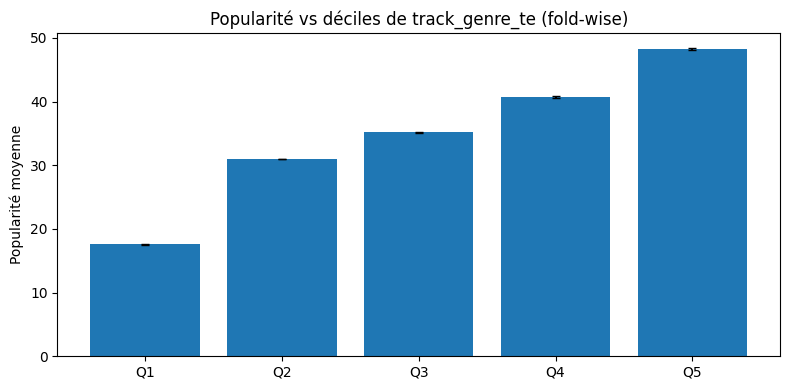

In [44]:
# @title Diagnostic target-encoding: popularité moyenne par quantile de track_genre_te
import numpy as np, pandas as pd, matplotlib.pyplot as plt

assert 'track_genre_te' in df_train.columns
q = pd.qcut(df_train['track_genre_te'], q=10, duplicates='drop')
means = df_train.groupby(q)['popularity'].mean()
errs  = df_train.groupby(q)['popularity'].std()/np.sqrt(df_train.groupby(q)['popularity'].size())

plt.figure(figsize=(8,4))
plt.bar(range(len(means)), means.values, yerr=errs.values, capsize=3)
plt.xticks(range(len(means)), [f"Q{i+1}" for i in range(len(means))])
plt.ylabel("Popularité moyenne")
plt.title("Popularité vs déciles de track_genre_te (fold-wise)")
plt.tight_layout(); plt.show()

## 2) Identifications des distributions et tendances

In [45]:
# @title === SCAN DISTRIBUTIONS & RECO ===
import numpy as np, pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer

# Reprend tes listes (V3)
cont_cols = [
    'danceability','energy','loudness','speechiness','acousticness',
    'instrumentalness','liveness','valence','tempo','duration_ms','track_genre_te'
]

def suggest_transform(series: pd.Series):
    """Retourne une reco parmi: none, log1p, winsor, yeo-johnson, quantile."""
    x = pd.to_numeric(series, errors='coerce').dropna().values
    n = len(x)
    if n < 100:  # trop petit pour juger finement
        return "none"
    skew = stats.skew(x)
    kurt = stats.kurtosis(x)
    # test normalité (K²) quand c'est raisonnable
    try:
        k2, p = stats.normaltest(x) if n <= 200_000 else (np.nan, np.nan)
    except Exception:
        k2, p = (np.nan, np.nan)

    # règles simples et robustes
    # (tu peux les resserrer si tu veux être plus/moins agressif)
    if np.nan_to_num(p) > 0.05 and abs(skew) < 0.75 and abs(kurt) < 3.5:
        return "none"
    if (series.min() >= 0) and (skew > 1.0):
        return "log1p"          # typique: duration_ms, speechiness, liveness
    if abs(skew) > 1.5 or abs(kurt) > 7:
        return "winsor"         # trop de queues -> clipping quantiles
    if abs(skew) > 0.75:
        return "yeo-johnson"    # donne souvent mieux que log si valeurs négatives possibles
    return "quantile"           # file de secours pour distributions très bizarres

def scan_distributions(df, cols):
    rows = []
    for c in cols:
        s = pd.to_numeric(df[c], errors='coerce')
        s = s[~s.isna()]
        if len(s) == 0:
            rows.append((c, np.nan, np.nan, np.nan, "none"))
            continue
        skew = stats.skew(s.values)
        kurt = stats.kurtosis(s.values)
        try:
            k2, p = stats.normaltest(s.values if len(s) <= 200_000 else s.sample(200_000, random_state=0).values)
        except Exception:
            k2, p = (np.nan, np.nan)
        rec = suggest_transform(s)
        rows.append((c, skew, kurt, p, rec))
    return pd.DataFrame(rows, columns=["feature","skew","kurtosis","p_normaltest","recommendation"])

scan_df = scan_distributions(df_train, cont_cols).sort_values("recommendation")
scan_df

,feature,skew,kurtosis,p_normaltest,recommendation
3,speechiness,4.421516,21.910091,0.0,log1p
5,instrumentalness,1.637158,0.946332,0.0,log1p
6,liveness,2.128289,4.646977,0.0,log1p
9,duration_ms,7.967598,174.124415,0.0,log1p
0,danceability,-0.291979,-0.373425,0.0,quantile
1,energy,-0.207246,-1.076672,0.0,quantile
4,acousticness,0.307032,-1.493883,0.0,quantile
7,valence,0.005384,-1.075419,0.0,quantile
8,tempo,0.377274,-0.254851,0.0,quantile
10,track_genre_te,-0.091282,2.686020,0.0,quantile


In [46]:
# @title Preprocesseur V3+
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer
import numpy as np
import pandas as pd


# Recommandations -> listes de colonnes par type de transform
rec_map = dict(zip(scan_df["feature"], scan_df["recommendation"]))
cols_log1p      = [c for c,r in rec_map.items() if r == "log1p"]
cols_winsor     = [c for c,r in rec_map.items() if r == "winsor"]
cols_yeojohnson = [c for c,r in rec_map.items() if r == "yeo-johnson"]
cols_quantile   = [c for c,r in rec_map.items() if r == "quantile"]
cols_none       = [c for c,r in rec_map.items() if r == "none"]

def winsorize_df(X, q_low=0.01, q_high=0.99):
    X = X.copy()
    for c in X.columns:
        lo, hi = np.quantile(X[c].values, [q_low, q_high])
        X[c] = np.clip(X[c].values, lo, hi)
    return X

winsor_tf = FunctionTransformer(lambda X: winsorize_df(pd.DataFrame(X, columns=cols_winsor)).values, feature_names_out="one-to-one")
log1p_tf  = FunctionTransformer(lambda X: np.log1p(np.clip(X, a_min=-0.999999, a_max=None)))
# Yeo-Johnson & Quantile
yeoj_tf   = PowerTransformer(method="yeo-johnson", standardize=False)
quant_tf  = QuantileTransformer(output_distribution="normal", n_quantiles=1000, subsample=200000, random_state=0)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

bin_cols      = ['explicit','mode']
low_card_cols = ['key','time_signature']
# Added 'track_genre_te' to cont_cols
cont_cols = list(rec_map.keys())

cont_blocks = []
if cols_none:
    cont_blocks.append(("cont_none", Pipeline([("imp", SimpleImputer(strategy="median"))]), cols_none))
if cols_log1p:
    cont_blocks.append(("cont_log1p", Pipeline([("imp", SimpleImputer(strategy="median")),("log", log1p_tf)]), cols_log1p))
if cols_winsor:
    cont_blocks.append(("cont_winsor", Pipeline([("imp", SimpleImputer(strategy="median")),("win", winsor_tf)]), cols_winsor))
if cols_yeojohnson:
    cont_blocks.append(("cont_yeoj", Pipeline([("imp", SimpleImputer(strategy="median")),("yeoj", yeoj_tf)]), cols_yeojohnson))
if cols_quantile:
    cont_blocks.append(("cont_quant", Pipeline([("imp", SimpleImputer(strategy="median")),("qt", quant_tf)]), cols_quantile))

cont_all = cols_none + cols_log1p + cols_winsor + cols_yeojohnson + cols_quantile
assert set(cont_all) == set(cont_cols), "Incohérence colonnes continues"

bin_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                     ("ohe", OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])
low_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                     ("ohe", OneHotEncoder(handle_unknown='ignore'))])

preprocessor_v3_plus = ColumnTransformer(cont_blocks + [
    ('bin',  bin_pipe,  bin_cols),
    ('low',  low_pipe,  low_card_cols),
], sparse_threshold=1.0)

print("Préprocesseur V3+ prêt (transfos data-driven).")

Préprocesseur V3+ prêt (transfos data-driven).


# III - Entrainement du modèle final

In [47]:
# @title Découpage des données
from sklearn.model_selection import train_test_split

# === Données ===
X = df_train.drop(columns=['popularity'])
y = df_train['popularity']

# Découpage train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
# @title MoE clusters (GMM) — version rapide sans CV (responsabilités + experts pondérés)
import numpy as np, pandas as pd, os
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

seed = 0
K_CLUST = 4
prepro = preprocessor_v3_plus
xgb_params = dict(
    learning_rate=0.032, max_depth=12, n_estimators=3000,
    subsample=0.8, colsample_bytree=0.65,
    min_child_weight=1, reg_lambda=0.9, reg_alpha=0.05,
    tree_method='hist', random_state=seed, n_jobs=-1
)

# Espace latent robuste (pas de PCA)
latent_cols = [c for c in ["energy","loudness","acousticness","danceability","speechiness","valence","tempo","duration_ms","year_norm"] if c in df_train.columns]
sc = StandardScaler()
Z_tr = sc.fit_transform(df_train[latent_cols].fillna(df_train[latent_cols].median()))
Z_te = sc.transform(df_test[latent_cols].fillna(df_train[latent_cols].median()))

# Router GMM: fit full train, responsabilités = proba clusters
gmm = GaussianMixture(n_components=K_CLUST, covariance_type="full", random_state=seed)
gmm.fit(Z_tr)
Q_tr = gmm.predict_proba(Z_tr)  # (n,K)
Q_te = gmm.predict_proba(Z_te)  # (m,K)

# Experts XGB avec sample_weight = responsabilités
y_tr = df_train["popularity"].values
experts = []
for k in range(K_CLUST):
    pipe = Pipeline([
        ("preprocess", prepro),
        ("model", XGBRegressor(**xgb_params))
    ])
    sw = Q_tr[:, k]
    pipe.fit(df_train.drop(columns=["popularity"], errors="ignore"), y_tr,
             model__sample_weight=sw)
    experts.append(pipe)

# Prédictions pondérées
preds_tr = np.column_stack([exp.predict(df_train.drop(columns=["popularity"], errors="ignore")) for exp in experts])
preds_te = np.column_stack([exp.predict(df_test.drop(columns=[], errors="ignore")) for exp in experts])
y_hat_tr = np.clip((Q_tr * preds_tr).sum(axis=1), 0, 100)
y_hat_te = np.clip((Q_te * preds_te).sum(axis=1), 0, 100)

# R² local proxy (router sur X_test)
try:
    Z_hold = sc.transform(X_test[latent_cols].fillna(df_train[latent_cols].median()))
    Q_hold = gmm.predict_proba(Z_hold)
    preds_hold = np.column_stack([exp.predict(X_test) for exp in experts])
    y_hold = np.clip((Q_hold * preds_hold).sum(axis=1), 0, 100)
    print(f"🧪 R² local (MoE clusters, no-CV) = {r2_score(y_test, y_hold):.4f}")
except Exception as e:
    print("(skip) R² local proxy non calculé :", e)

# Soumission
os.makedirs("submissions", exist_ok=True)
pd.DataFrame({"id": np.arange(len(y_hat_te)), "popularity": y_hat_te}).to_csv(
    "submissions/submission_moe_clusters_fast.csv", index=False
)
print("✅ Soumission écrite: submissions/submission_moe_clusters_fast.csv")

🧪 R² local (MoE clusters, no-CV) = 0.9796
✅ Soumission écrite: submissions/submission_moe_clusters_fast.csv


In [26]:
# @title Helper: écrire une soumission Kaggle valide (row_id aligné)
import numpy as np, pandas as pd, os

def write_submission_kaggle(df_test, y_pred, path):
    sub = pd.DataFrame({
        "row_id": (df_test["row_id"].astype(int) if "row_id" in df_test.columns
                   else np.arange(len(df_test), dtype=int)),
        "popularity": np.clip(np.asarray(y_pred, dtype=float), 0, 100)
    })
    # Checks utiles
    assert len(sub) == len(df_test), "Taille prédictions ≠ taille test"
    assert sub["row_id"].is_unique, "row_id dupliqués !"
    # tri optionnel (si Kaggle exige tri exact)
    sub = sub.sort_values("row_id").reset_index(drop=True)
    os.makedirs("submissions", exist_ok=True)
    sub.to_csv(path, index=False)
    print(f"✅ Fichier écrit: {path} | shape={sub.shape} | row_id min/max =",
          int(sub.row_id.min()), int(sub.row_id.max()))

In [27]:
write_submission_kaggle(df_test, y_hat_te, "submissions/submission_moe_clusters_fast.csv")

✅ Fichier écrit: submissions/submission_moe_clusters_fast.csv | shape=(28500, 2) | row_id min/max = 85500 113999


# Annexe - Historiques des modèles entrainées

In [ ]:
# @title SVM (SVR) — grille compacte + R²(test)
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np

grid = {
    "C":       [0.5, 1.0, 2.0],
    "epsilon": [0.1, 0.2],
    "kernel":  ["rbf"],   # 'rbf' pour non-linéaire
    "gamma":   ["scale"], # gamma auto
}
print("Nombre de combinaisons testées:", len(grid["C"])*len(grid["epsilon"])*len(grid["kernel"])*len(grid["gamma"]))

best = (-1e9, None, None)
for C in grid["C"]:
    for eps in grid["epsilon"]:
        for ker in grid["kernel"]:
            for gm in grid["gamma"]:
                params = dict(C=C, epsilon=eps, kernel=ker, gamma=gm)
                pipe = Pipeline([
                    ("preprocess", preprocessor_v3_plus),
                    ("model", SVR(**params))
                ])
                pipe.fit(X_train, y_train)
                preds = np.clip(pipe.predict(X_test), 0, 100)
                r2 = r2_score(y_test, preds)
                print(f"SVR C={C}, eps={eps}, kernel={ker} -> R²={r2:.4f}")
                if r2 > best[0]:
                    best = (r2, params, pipe)

print("\n[SVR] Best params:", best[1], "| R²(test)=", f"{best[0]:.4f}")

In [ ]:
# @title AdaBoostRegressor — grille légère + R²(test)
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np

grid = {
    "n_estimators":   [300, 600],
    "learning_rate":  [0.05, 0.10],
    "max_depth_base": [3, 5],
}
print("Nombre de combinaisons testées:", len(grid["n_estimators"])*len(grid["learning_rate"])*len(grid["max_depth_base"]))

best = (-1e9, None, None)
for ne in grid["n_estimators"]:
    for lr in grid["learning_rate"]:
        for md in grid["max_depth_base"]:
            base = DecisionTreeRegressor(max_depth=md, random_state=0)
            model = AdaBoostRegressor(
                estimator=base, n_estimators=ne, learning_rate=lr, random_state=0
            )
            pipe = Pipeline([
                ("preprocess", preprocessor_v3_plus),
                ("model", model)
            ])
            pipe.fit(X_train, y_train)
            preds = np.clip(pipe.predict(X_test), 0, 100)
            r2 = r2_score(y_test, preds)
            print(f"AdaBoost n={ne}, lr={lr}, depth={md} -> R²={r2:.4f}")
            if r2 > best[0]:
                best = (r2, {"n_estimators":ne,"learning_rate":lr,"max_depth_base":md}, pipe)

print("\n[AdaBoost] Best params:", best[1], "| R²(test)=", f"{best[0]:.4f}")

In [ ]:
# @title RandomForestRegressor — boucle manuelle + R²(test)
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np

grid = {
    "n_estimators": [300, 600],
    "max_depth":    [12, 20, None],
    "max_features": ["sqrt", 0.7],
    "min_samples_leaf": [1, 3],
}
def ncomb(g):
    m=1
    for v in g.values(): m*=len(v)
    return m
print("Nombre de combinaisons testées:", ncomb(grid))

best = (-1e9, None, None)
for ne in grid["n_estimators"]:
    for md in grid["max_depth"]:
        for mf in grid["max_features"]:
            for msl in grid["min_samples_leaf"]:
                params = dict(
                    n_estimators=ne, max_depth=md, max_features=mf,
                    min_samples_leaf=msl, n_jobs=-1, random_state=0
                )
                pipe = Pipeline([
                    ("preprocess", preprocessor_v3_plus),
                    ("model", RandomForestRegressor(**params))
                ])
                pipe.fit(X_train, y_train)
                preds = np.clip(pipe.predict(X_test), 0, 100)
                r2 = r2_score(y_test, preds)
                print(f"RF n={ne}, depth={md}, max_feat={mf}, leaf={msl} -> R²={r2:.4f}")
                if r2 > best[0]:
                    best = (r2, params, pipe)

print("\n[RF] Best params:", best[1], "| R²(test)=", f"{best[0]:.4f}")

In [ ]:
# @title GradientBoostingRegressor — grille compacte + R²(test)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np

grid = {
    "learning_rate": [0.05, 0.10],
    "n_estimators":  [800, 1200],
    "max_depth":     [2, 3],
    "subsample":     [1.0, 0.8]
}
print("Nombre de combinaisons testées:", len(grid["learning_rate"])*len(grid["n_estimators"])*len(grid["max_depth"])*len(grid["subsample"]))

best = (-1e9, None, None)
for lr in grid["learning_rate"]:
    for ne in grid["n_estimators"]:
        for md in grid["max_depth"]:
            for ss in grid["subsample"]:
                params = dict(learning_rate=lr, n_estimators=ne, max_depth=md, subsample=ss, random_state=0)
                pipe = Pipeline([
                    ("preprocess", preprocessor_v3_plus),
                    ("model", GradientBoostingRegressor(**params))
                ])
                pipe.fit(X_train, y_train)
                preds = np.clip(pipe.predict(X_test), 0, 100)
                r2 = r2_score(y_test, preds)
                print(f"GB lr={lr}, n={ne}, depth={md}, subsample={ss} -> R²={r2:.4f}")
                if r2 > best[0]:
                    best = (r2, params, pipe)

print("\n[GB] Best params:", best[1], "| R²(test)=", f"{best[0]:.4f}")

In [ ]:
# @title LightGBM (LGBMRegressor) — mini-sweep stable + R²(test)
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np

grid = {
    "learning_rate":     [0.05, 0.10],
    "n_estimators":      [1200, 1600],
    "num_leaves":        [96, 128, 160],
    "max_depth":         [12],
    "feature_fraction":  [0.7, 0.8],
    "bagging_fraction":  [0.8, 0.9],
    "bagging_freq":      [1],
    "min_child_samples": [10, 20],
    "reg_lambda":        [0.0, 0.5, 1.0],
}
def ncomb(g):
    m=1
    for v in g.values(): m*=len(v)
    return m
print("Nombre de combinaisons testées:", ncomb(grid))

best = (-1e9, None, None)
for lr in grid["learning_rate"]:
    for ne in grid["n_estimators"]:
        for nl in grid["num_leaves"]:
            for ff in grid["feature_fraction"]:
                for bf in grid["bagging_fraction"]:
                    for mcs in grid["min_child_samples"]:
                        for rl in grid["reg_lambda"]:
                            params = dict(
                                learning_rate=lr, n_estimators=ne, num_leaves=nl,
                                max_depth=12, feature_fraction=ff,
                                bagging_fraction=bf, bagging_freq=1,
                                min_child_samples=mcs, reg_lambda=rl,
                                objective="regression", random_state=0, n_jobs=-1
                            )
                            pipe = Pipeline([
                                ("preprocess", preprocessor_v3_plus),
                                ("model", LGBMRegressor(**params))
                            ])
                            pipe.fit(X_train, y_train)
                            preds = np.clip(pipe.predict(X_test), 0, 100)
                            r2 = r2_score(y_test, preds)
                            print(f"LGBM lr={lr}, n={ne}, leaves={nl}, ff={ff}, bf={bf}, mcs={mcs}, rl={rl} -> R²={r2:.4f}")
                            if r2 > best[0]:
                                best = (r2, params, pipe)

print("\n[LGBM] Best params:", best[1], "| R²(test)=", f"{best[0]:.4f}")

In [ ]:
pip install catboost

In [ ]:
# @title CatBoostRegressor — grille raisonnable + R²(test)
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np

grid = {
    "learning_rate": [0.05, 0.10],
    "depth":         [8, 10, 12],
    "n_estimators":  [1200, 1600],
    "l2_leaf_reg":   [3, 5],
    "bagging_temperature": [0.25, 0.5],
}
print("Nombre de combinaisons testées:", len(grid["learning_rate"])*len(grid["depth"])*len(grid["n_estimators"])*len(grid["l2_leaf_reg"])*len(grid["bagging_temperature"]))

best = (-1e9, None, None)
for lr in grid["learning_rate"]:
    for dp in grid["depth"]:
        for ne in grid["n_estimators"]:
            for l2 in grid["l2_leaf_reg"]:
                for bt in grid["bagging_temperature"]:
                    params = dict(
                        learning_rate=lr, depth=dp, n_estimators=ne,
                        l2_leaf_reg=l2, bagging_temperature=bt,
                        loss_function="RMSE", random_state=0, verbose=False
                    )
                    # NB: preprocessor_v3_plus One-Hot déjà → on passe CatBoost en "numérique"
                    pipe = Pipeline([
                        ("preprocess", preprocessor_v3_plus),
                        ("model", CatBoostRegressor(**params))
                    ])
                    pipe.fit(X_train, y_train)
                    preds = np.clip(pipe.predict(X_test), 0, 100)
                    r2 = r2_score(y_test, preds)
                    print(f"CAT lr={lr}, depth={dp}, n={ne}, l2={l2}, bt={bt} -> R²={r2:.4f}")
                    if r2 > best[0]:
                        best = (r2, params, pipe)

print("\n[CatBoost] Best params:", best[1], "| R²(test)=", f"{best[0]:.4f}")

# Visualisation importances variables XGBoost

In [48]:
# @title XGBoost — entraînement final pour visualisations
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np

# Paramètres finaux
xgb_params_final = dict(
    learning_rate=0.032, max_depth=12, n_estimators=3000,
    subsample=0.8, colsample_bytree=0.65,
    min_child_weight=1, reg_lambda=0.9, reg_alpha=0.05,
    tree_method='hist', random_state=seed, n_jobs=-1
)

# Pipeline complet
pipe_xgb_final = Pipeline([
    ("preprocess", preprocessor_v3_plus),
    ("model", XGBRegressor(**xgb_params_final))
])

# Entraînement
pipe_xgb_final.fit(X_train, y_train)
y_pred_final = np.clip(pipe_xgb_final.predict(X_test), 0, 100)
r2_final = r2_score(y_test, y_pred_final)
print(f"[XGB final] R²(test) = {r2_final:.4f}")

# ✅ prêt pour plots : importances, PDP, calibration, etc.
single_pipe = pipe_xgb_final
single_hold = y_pred_final

[XGB final] R²(test) = 0.7254


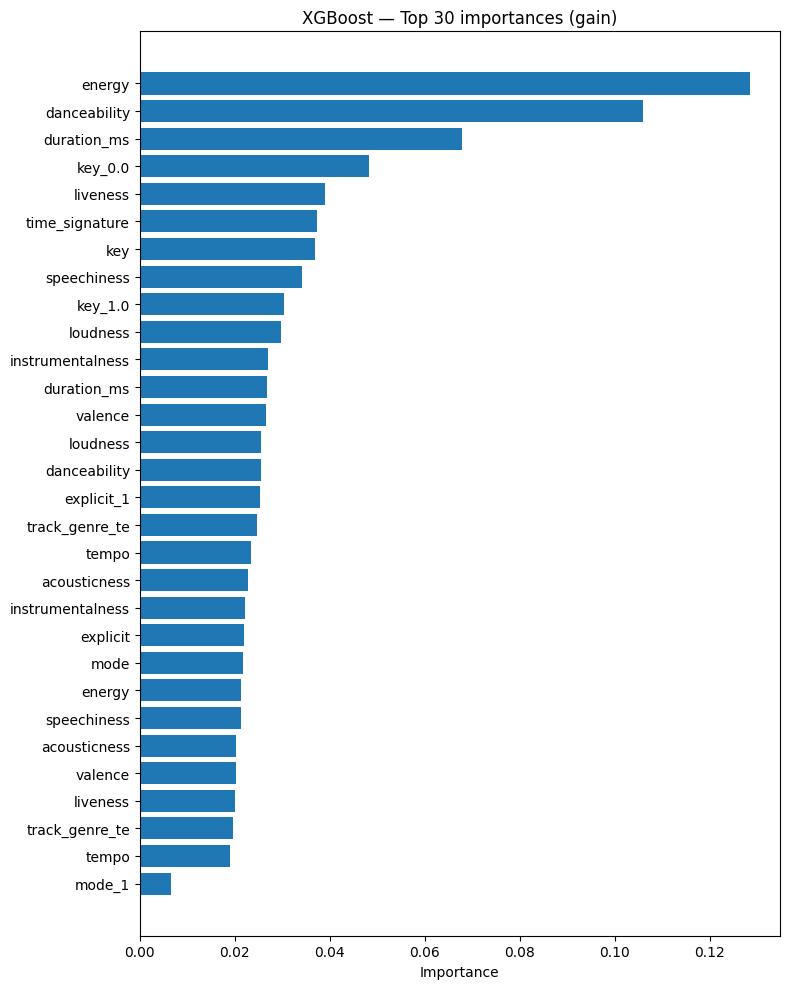

In [53]:
# @title Importances XGBoost (top 30) avec noms de features réels
import numpy as np, matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Choisir le pipeline entraîné
xgb_pipe = single_pipe  # <- si tu utilises pipe_lossguide_best, remplace ici

# Récupération des noms de features du préprocesseur
def get_feature_names(preprocessor, X_df):
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'remainder':
            # For 'remainder', use the column names directly
            remaining_cols = [col for col in X_df.columns if col not in preprocessor.transformers_[0][2] + preprocessor.transformers_[1][2] + preprocessor.transformers_[2][2] + preprocessor.transformers_[3][2] + preprocessor.transformers_[4][2]]
            names.extend(remaining_cols)
        elif isinstance(trans, Pipeline):
            # If it's a pipeline, iterate through steps
            for step_name, step_trans in trans.steps:
                if hasattr(step_trans, 'get_feature_names_out'):
                     names.extend(step_trans.get_feature_names_out(cols))
                elif isinstance(step_trans, FunctionTransformer):
                    # Handle FunctionTransformer by using original column names
                    names.extend(cols)
                else:
                    # Fallback for other transformers in a pipeline
                    names.extend(cols)
        elif hasattr(trans, 'get_feature_names_out'):
            # If the transformer has get_feature_names_out, use it
            names.extend(trans.get_feature_names_out(cols))
        elif isinstance(trans, FunctionTransformer):
             # Handle FunctionTransformer in the top level
             names.extend(cols)
        else:
            # Fallback for other transformers
            names.extend(cols if isinstance(cols, list) else list(cols))
    return np.array(names)


feat_names = get_feature_names(xgb_pipe.named_steps['preprocess'], X_train)
booster = xgb_pipe.named_steps['model']
imp = booster.feature_importances_

order = np.argsort(imp)[::-1][:30]
plt.figure(figsize=(8,10))
plt.barh(range(len(order)), imp[order][::-1])
plt.yticks(range(len(order)), feat_names[order][::-1])
plt.title("XGBoost — Top 30 importances (gain)")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()